# BGC Argo+ Demo

## 0. Setup & helpers

In [123]:
from argovisHelpers import helpers as avh
import numpy, scipy.interpolate, math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def simple_map(longitudes, latitudes, z=None, zlabel=None, markers=None, polygon=None, polygonweight=5, title='', fig=None, figIndex=None, spot=None, suppress_colorbar=False, font_size=20, secondaries=None):
    if fig:
        ax = fig.add_subplot(figIndex[0], figIndex[1], figIndex[2], projection=ccrs.LambertConformal())
    else:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
    gl = ax.gridlines(draw_labels=True,color='black')
    if z:
        s = ax.scatter(longitudes, latitudes, c=z, transform=ccrs.PlateCarree())
        if not suppress_colorbar:
            cb = plt.colorbar(s, pad=0.1)
            if zlabel:
                cb.set_label(zlabel, rotation=270, labelpad=20, size=font_size)
    elif markers:
        lons = numpy.array(longitudes)
        lats = numpy.array(latitudes)
        marks = numpy.array(markers)
        ms = set(markers)
        for m in ms:
            s = ax.scatter(lons[marks==m],lats[marks==m], marker=m,transform=ccrs.PlateCarree())
    else:
        s = ax.scatter(longitudes, latitudes,transform=ccrs.PlateCarree())
    if polygon: 
        plt.plot(polygon_lon_lat(str(polygon))['lon'],polygon_lon_lat(str(polygon))['lat'],'-k',transform=ccrs.PlateCarree(), linewidth=polygonweight, color='red')
    if secondaries:
        for sec in secondaries:
            ax.scatter(sec['lon'], sec['lat'],transform=ccrs.PlateCarree(), color=sec['color'], marker='x', s=150, linewidth=3)
    if spot:
        plt.plot(spot[0],spot[1],'Xr', transform=ccrs.PlateCarree(), markersize=20)
    plt.rcParams['font.size'] = font_size
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    plt.title(title, fontdict={'fontsize':font_size})

def tidy_profile(pressure, var):
    # tidy up profile for pchip

    ## dependent variable must be defined
    mask = [0]*len(var)
    for i in range(len(var)):
        if var[i] is None or math.isnan(var[i]):
            mask[i] = 1
    p = [pressure[i] for i in range(len(mask)) if mask[i]==0]
    v = [var[i] for i in range(len(mask)) if mask[i]==0]

    ## pressure must be defined
    mask = [0]*len(p)
    for i in range(len(p)):
        if p[i] is None or math.isnan(p[i]):
            mask[i] = 1
    p = [p[i] for i in range(len(mask)) if mask[i]==0]
    v = [v[i] for i in range(len(mask)) if mask[i]==0]

    ## drop degenerate levels
    mask = [0]*len(p)
    for i in range(len(p)-1):
        if p[i] == p[i+1]:
            mask[i] = 1
            mask[i+1] = 1
    p = [p[i] for i in range(len(mask)) if mask[i]==0]
    v = [v[i] for i in range(len(mask)) if mask[i]==0]

    if all(p[i] < p[i + 1] for i in range(len(p) - 1)):
        # pressure is monotonically increasing, return
        return p, v

    if all(p[i] > p[i + 1] for i in range(len(p) - 1)):
        # pressure is monotonically decreasing, reverse and return
        return p[::-1], v[::-1]

    # pressure is non-monotonic, sort and try again
    x = sorted(zip(p,v))
    p = [element[0] for element in x]
    v = [element[1] for element in x]
    return tidy_profile(p,v)

def simple_interpolate(pres, var, levels):
    # interpolate <var> to <levels> using PCHIP interpolation

    pressure, variable = tidy_profile(pres, var)

    # ROI must contain at least two points for Pchip
    if len(pressure) < 2:
        interp = numpy.full(len(levels), numpy.nan)
        return interp
    else:
        # interpolate; don't extrapolate to levels outside of measurement range
        interp = scipy.interpolate.PchipInterpolator(pressure, variable, extrapolate=False)(levels)

        return interp

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY='guest'

## 1. Accessing Argo BGC+ data

Let's begin by fetching the BGC Argo+ profiles associated with a given probe and map their location:

In [112]:
qsp = {
    'platform': '5903889',
    'data': 'all'
}

float_profiles = avh.query('bgcargoplus', options=qsp, apikey=API_KEY, apiroot=API_ROOT, verbose=True)

https://argovis-api.colorado.edu/bgcargoplus?platform=5903889&data=all


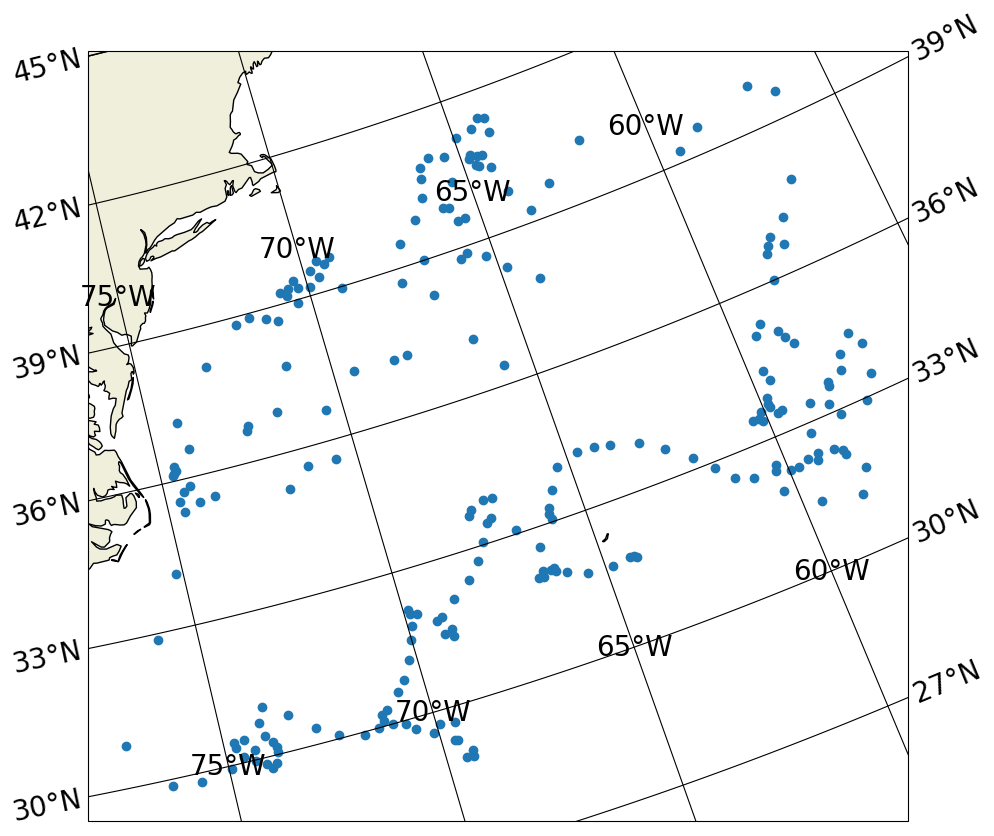

In [113]:
float_longitudes = [x['geolocation']['coordinates'][0] for x in float_profiles]
float_latitudes  = [x['geolocation']['coordinates'][1] for x in float_profiles]
simple_map(float_longitudes,float_latitudes)

The BGC Argo+ dataset presents Argo BGC data with expert QC applied; as with all datasets indexed by Argovis, we can extract the variables available from a given profile per the following: 

In [114]:
profile = float_profiles[-1]
print(profile['data_info'])

[['pressure', 'TEMP_ADJUSTED_RO', 'PSAL_ADJUSTED_RO', 'DOXY_ADJUSTED_RO'], ['units', 'mode'], [['decibar', 'D'], ['degree_Celsius', 'D'], ['psu', 'D'], ['micromole/kg', 'D']]]


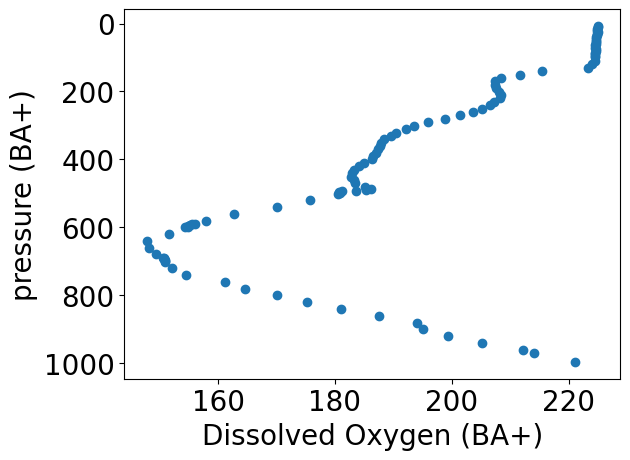

In [115]:
pressure = profile['data'][profile['data_info'][0].index('pressure')]
doxy = profile['data'][profile['data_info'][0].index('DOXY_ADJUSTED_RO')]

plt.scatter(doxy, pressure)
plt.xlabel("Dissolved Oxygen (BA+)")
plt.ylabel("pressure (BA+)")
plt.gca().invert_yaxis()
plt.show()

## 2. Comparing to current Argo profiles

While BGC Argo+ profiles were produced at a given point in time, the Argo GDACs release updates to existing profiles over time. What if we want to compare a BGC Argo+ variable to a variable in the corresponding upstream Argo profile, which Argovis updates nightly? We can find the corresponding profile as both Argovis' BGC Argo+ and upstream Argo profiles use the same document ID schema, `<floatnumber>_<cyclenumber>`:

In [116]:
print(profile['_id'])

5903889_223


In [117]:
qsp = {
    'id': profile['_id'],
    'data': 'all'
}

argo_profile = avh.query('argo', options=qsp, apikey=API_KEY, apiroot=API_ROOT, verbose=True)[0]

https://argovis-api.colorado.edu/argo?id=5903889_223&data=all


In [118]:
print(argo_profile['data_info'])

[['doxy', 'doxy_argoqc', 'pressure', 'pressure_argoqc', 'salinity', 'salinity_argoqc', 'salinity_sfile', 'salinity_sfile_argoqc', 'temperature', 'temperature_argoqc', 'temperature_sfile', 'temperature_sfile_argoqc'], ['units', 'data_keys_mode'], [['micromole/kg', 'D'], [None, None], ['decibar', 'D'], [None, None], ['psu', 'D'], [None, None], ['psu', 'D'], [None, None], ['degree_Celsius', 'D'], [None, None], ['degree_Celsius', 'D'], [None, None]]]


Our strategy to compare variables across the two representations of the same profile is to interpolate the variables of interest to a common level spectrum; we'll use the Roemmich-Gilson levels here:

In [124]:
RG_levels = [2.5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,182.5,200,220,240,260,280,300,320,340,360,380,400,420,440,462.5,500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1412.5,1500,1600,1700,1800,1900,1975]

doxy_bap_interpolated = simple_interpolate(pressure, doxy, RG_levels)

pressure_core = argo_profile['data'][argo_profile['data_info'][0].index('pressure')]
temperature_core = argo_profile['data'][argo_profile['data_info'][0].index('temperature')]
temperature_core_interpolated = simple_interpolate(pressure_core, temperature_core, RG_levels)

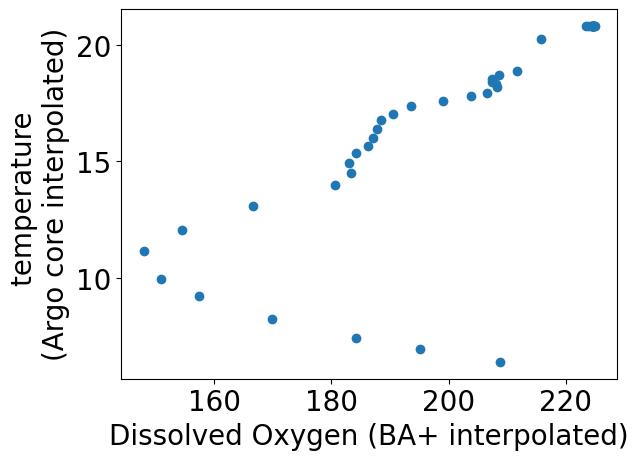

In [130]:
plt.scatter(doxy_bap_interpolated, temperature_core_interpolated)
plt.xlabel("Dissolved Oxygen (BA+ interpolated)")
plt.ylabel("temperature \n(Argo core interpolated)")
plt.show()

Any two arbitrary variables from either representation of the profile (upstream Argo or Argo BGC+) can be compared in this way.